# Implementation of matrix factorization using SVD for getting recommendations.

## Imports

In [2]:
import sys
sys.path.append("../")

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import typing as tp
import numpy as np

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from src.utils import rec_imaging

## Data preparation

In [5]:
interactions = pd.read_csv("../data/BX-Book-Ratings.csv", sep=";", encoding="unicode-escape")
books = pd.read_csv("../data/BX-Books.csv", low_memory=False)
users = pd.read_csv("../data/BX-Users.csv", sep=";", encoding="unicode-escape")

Merge tables, so that it'll be possible to get item name and image url of item to view it later.

In [6]:
interactions = (
    interactions
    .merge(
        books[["ISBN", "Book-Title", "Image-URL-M"]],
        how="left",
        on="ISBN"
    )
)

Rename columns for convenience.

In [7]:
interactions = interactions.rename(
    columns={
        "User-ID": "user_id",
        "ISBN": "item_id",
        "Book-Rating": "score",
        "Book-Title": "item_name",
        "Image-URL-M": "image_url"
    }
)

Preprocess interactions.

In [9]:
interactions = interactions[interactions["item_name"].notna()]
interactions = interactions[interactions["score"] > 0]
le = LabelEncoder()
interactions["item_id"] = le.fit_transform(interactions["item_id"])
interactions["user_id"] = le.fit_transform(interactions["user_id"])

In [10]:
interactions = (
    interactions
    .groupby(["user_id", "item_id"])
    .agg({
        "score": "sum",
        "item_name": "first",
        "image_url": "first"
    })
    .reset_index()
)

## Model

In [29]:
class MatrixFactorization:
    def __init__(
        self,
        interactions_df: pd.DataFrame,
    ) -> None:
        self.content_dict = {}
        self.interactions_df = interactions_df

        # Fill dict with content
        for i, j, k in self.interactions_df[["item_id", "item_name", "image_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = {
                "name": j,
                "image_url": k
            }

        # Create matrix in COO format
        self.coo_rates: coo_matrix = coo_matrix(
            (
                self.interactions_df["score"],
                (self.interactions_df["user_id"], self.interactions_df["item_id"])
            ),
            shape=(len(set(self.interactions_df["user_id"])), len(set(self.interactions_df["item_id"])))
        )

    def MF(
        self,
        k: int = 30
    ) -> None:
        """Makes SVD decomposition and get latent representations of users and items."""
        U, S, V = svds(self.coo_rates.astype(float), k=k)

        self.user_embeddings = U
        self.item_embeddings = V.T

    def get_rec(
        self,
        i: int
    ) -> None:
        metrics = cosine_similarity([self.item_embeddings[i]], self.item_embeddings)
        print("For item:")
        rec_imaging([i], self.content_dict)
        print("Such recommendations:")
        rec_imaging(
            np.argsort(-metrics)[0][1:11],
            self.content_dict,
            -np.round(np.sort(-metrics)[0][1:11], 4)
        )

In [30]:
model = MatrixFactorization(interactions)

## View recommendations

In [47]:
model.MF(k=50)

In [48]:
HARRY_ID = 46425
HOBBIT_ID = 24535

For item:


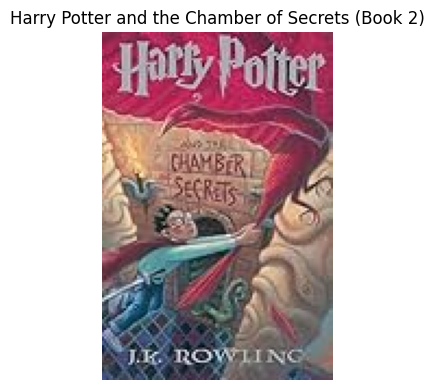

Such recommendations:


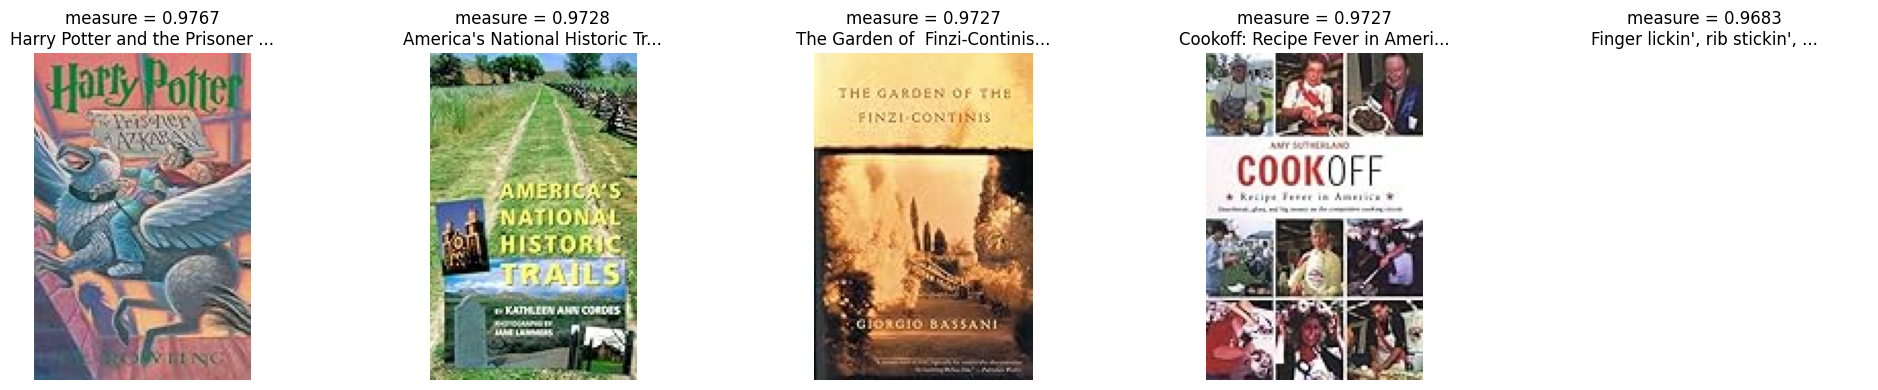

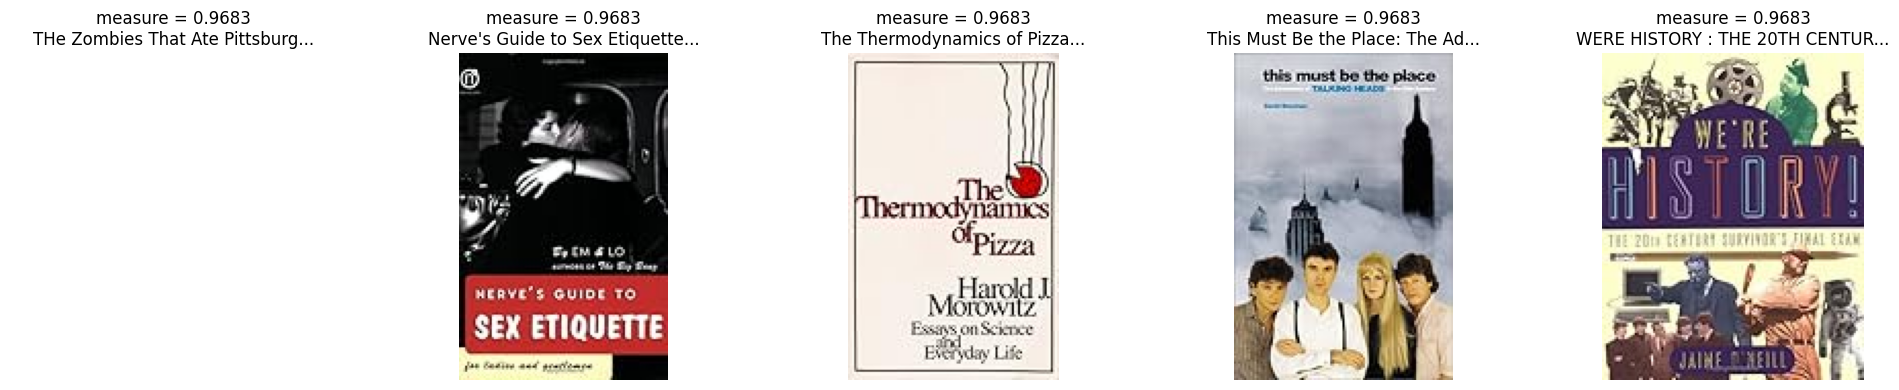

In [50]:
model.get_rec(46019)